In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score

from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Exploratory Data Analysis

In [3]:
df = pd.read_csv('/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv')
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
print(df.head())

   step      type    amount     nameOrig  oldBalanceOrig  newBalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815        170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295         21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145           181.0            0.00   
3     1  CASH_OUT    181.00   C840083671           181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720         41554.0        29885.86   

      nameDest  oldBalanceDest  newBalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [4]:
df = df.drop(['isFlaggedFraud'],axis=1)
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldBalanceOrig',
       'newBalanceOrig', 'nameDest', 'oldBalanceDest', 'newBalanceDest',
       'isFraud'],
      dtype='object')

In [5]:
print("No. of fraud transactions: {}, No. of non-fraud transactions: {}".format((df.isFraud == 1).sum(),(df.isFraud == 0).sum()))

No. of fraud transactions: 8213, No. of non-fraud transactions: 6354407


In [6]:
dfFraud = df.loc[df.isFraud == 1]
dfNonFraud = df.loc[df.isFraud == 0]

In [7]:
print("What are the types for fraud transactions? {}".format(dfFraud.type.drop_duplicates().values))
print("\nHow many unique origins are there in fraud transfer transactions? {} / {}".format(len(dfFraud.loc[dfFraud.type == 'TRANSFER'].nameOrig.drop_duplicates().values),len(dfFraud.loc[dfFraud.type == 'TRANSFER'])))
print("How many unique destinations are there in fraud transfer transactions? {} / {}".format(len(dfFraud.loc[dfFraud.type == 'TRANSFER'].nameDest.drop_duplicates().values),len(dfFraud.loc[dfFraud.type == 'TRANSFER'])))
print("\nHow many unique origins are there in fraud cash out transactions? {} / {}".format(len(dfFraud.loc[dfFraud.type == 'CASH_OUT'].nameOrig.drop_duplicates().values),len(dfFraud.loc[dfFraud.type == 'CASH_OUT'])))
print("How many unique destinations are there in fraud cash out transactions? {} / {}".format(len(dfFraud.loc[dfFraud.type == 'CASH_OUT'].nameDest.drop_duplicates().values),len(dfFraud.loc[dfFraud.type == 'CASH_OUT'])))

What are the types for fraud transactions? ['TRANSFER' 'CASH_OUT']

How many unique origins are there in fraud transfer transactions? 4097 / 4097
How many unique destinations are there in fraud transfer transactions? 4097 / 4097

How many unique origins are there in fraud cash out transactions? 4116 / 4116
How many unique destinations are there in fraud cash out transactions? 4091 / 4116


In [8]:
dfFraudTransfer = dfFraud.loc[dfFraud.type == 'TRANSFER']
dfFraudCashout = dfFraud.loc[dfFraud.type == 'CASH_OUT']

print("How many fraud transfer transactions have destinations which are origins in fraud cash out transactions? {}".\
     format(dfFraudTransfer.nameDest.isin(dfFraudCashout.nameOrig.unique()).sum()))

print("\nHow many fraud transfer transactions have destinations which are origins in genuine cash out transactions? {}".\
     format(dfFraudTransfer.nameDest.isin(dfNonFraud.loc[dfNonFraud.type == 'CASH_OUT'].nameOrig.unique()).sum()))
print("How many genuine transfer transactions have destinations which are origins in fraud cash out transactions? {}".\
     format(dfNonFraud.loc[dfNonFraud.type == 'TRANSFER'].nameDest.isin(dfFraudCashout.nameOrig.unique()).sum()))

print("\nHow many genuine transfer transactions have destinations which are destinations in fraud transfer transactions? {}".\
     format(dfNonFraud.loc[dfNonFraud.type == 'TRANSFER'].nameDest.isin(dfFraudTransfer.nameDest.unique()).sum()))
print("How many genuine transfer transactions have origins which are destinations in fraud transfer transactions? {}".\
     format(dfNonFraud.loc[dfNonFraud.type == 'TRANSFER'].nameOrig.isin(dfFraudTransfer.nameDest.unique()).sum()))
print("How many genuine transfer transactions have origins which are origins in fraud transfer transactions? {}".\
     format(dfNonFraud.loc[dfNonFraud.type == 'TRANSFER'].nameOrig.isin(dfFraudTransfer.nameOrig.unique()).sum()))
print("How many genuine transfer transactions have destinations which are origins in fraud transfer transactions? {}".\
     format(dfNonFraud.loc[dfNonFraud.type == 'TRANSFER'].nameDest.isin(dfFraudTransfer.nameOrig.unique()).sum()))

How many fraud transfer transactions have destinations which are origins in fraud cash out transactions? 0

How many fraud transfer transactions have destinations which are origins in genuine cash out transactions? 3
How many genuine transfer transactions have destinations which are origins in fraud cash out transactions? 0

How many genuine transfer transactions have destinations which are destinations in fraud transfer transactions? 1701
How many genuine transfer transactions have origins which are destinations in fraud transfer transactions? 1
How many genuine transfer transactions have origins which are origins in fraud transfer transactions? 2
How many genuine transfer transactions have destinations which are origins in fraud transfer transactions? 0


In [9]:
print('Min, Max of Fraud Transactions: {} - {}'.format(dfFraud.amount.min(),dfFraud.amount.max()))
print('Min, Max of Non-Fraud Transactions: {} - {}'.format(dfNonFraud.amount.min(),dfNonFraud.amount.max()))

Min, Max of Fraud Transactions: 0.0 - 10000000.0
Min, Max of Non-Fraud Transactions: 0.01 - 92445516.64


# Data Cleaning

In [10]:
df.isnull().values.any()

False

In [11]:
print('% of fraud transactions in which \'oldBalanceDest\' \'newBalanceDest\' and amount is non-zero: {}'.format(len(dfFraud.loc[(dfFraud.oldBalanceDest == 0) & (dfFraud.newBalanceDest == 0) & (dfFraud.amount != 0) & (dfFraud.type.isin(['TRANSFER','CASH_OUT']))]) / len(dfFraud.loc[(dfFraud.type.isin(['TRANSFER','CASH_OUT']))])))
print('% of genuine transactions in which \'oldBalanceDest\' \'newBalanceDest\' and amount is non-zero: {}'.format(len(dfNonFraud.loc[(dfNonFraud.oldBalanceDest == 0) & (dfNonFraud.newBalanceDest == 0) & (dfNonFraud.amount != 0) & (dfNonFraud.type.isin(['TRANSFER','CASH_OUT']))]) / len(dfNonFraud.loc[(dfNonFraud.type.isin(['TRANSFER','CASH_OUT']))])))

% of fraud transactions in which 'oldBalanceDest' 'newBalanceDest' and amount is non-zero: 0.4955558261293072
% of genuine transactions in which 'oldBalanceDest' 'newBalanceDest' and amount is non-zero: 0.0006176245277308345


In [12]:
df['errorBalanceOrig'] = df.newBalanceOrig + df.amount - df.oldBalanceOrig
df['errorBalanceDest'] = df.oldBalanceDest + df.amount - df.newBalanceDest

In [13]:
print('Percentage of transactions with non-zero \'errorBalanceOrig\'')
pd.DataFrame(df.groupby('type').apply(lambda df:len(df.loc[df.errorBalanceOrig != 0]) / len(df)))

Percentage of transactions with non-zero 'errorBalanceOrig'


,0
type,
CASH_IN,1.000000
CASH_OUT,0.898052
DEBIT,0.329962
PAYMENT,0.594509
TRANSFER,0.958963


In [14]:
print('Percentage of transactions with non-zero \'errorBalanceDest\'')
pd.DataFrame(df.groupby('type').apply(lambda df:len(df.loc[df.errorBalanceDest != 0]) / len(df)))

Percentage of transactions with non-zero 'errorBalanceDest'


,0
type,
CASH_IN,1.000000
CASH_OUT,0.417347
DEBIT,0.475743
PAYMENT,1.000000
TRANSFER,0.436039


In [15]:
df.groupby('type').apply(lambda df:df.loc[df.errorBalanceDest != 0])

step      type      amount     nameOrig  oldBalanceOrig  \
type                                                                        
CASH_IN  389         1   CASH_IN   143236.26  C1862994526            0.00   
         390         1   CASH_IN   228451.89  C1614133563       143236.26   
         391         1   CASH_IN    35902.49   C839771540       371688.15   
         392         1   CASH_IN   232953.64  C1037163664       407590.65   
         393         1   CASH_IN    65912.95   C180316302       640544.28   
...                ...       ...         ...          ...             ...   
TRANSFER 6362610   742  TRANSFER    63416.99   C778071008        63416.99   
         6362612   743  TRANSFER  1258818.82  C1531301470      1258818.82   
         6362614   743  TRANSFER   339682.13  C2013999242       339682.13   
         6362616   743  TRANSFER  6311409.28  C1529008245      6311409.28   
         6362618   743  TRANSFER   850002.52  C1685995037       850002.52   

                  newBalanceOrig     nameDest  oldBalanceDest  newBalanceDest  \
type                                                                            
CASH_IN  389           143236.26  C1688019098       608932.17        97263.78   
         390           371688.15  C2083562754       719678.38      1186556.81   
         391           407590.65  C2001112025        49003.30            0.00   
         392           640544.28    C33524623      1172672.27      1517262.16   
         393           706457.23  C1330106945       104198.26        24044.18   
...                          ...          ...             ...             ...   
TRANSFER 6362610            0.00  C1812552860            0.00            0.00   
         6362612            0.00  C1470998563            0.00            0.00   
         6362614            0.00  C1850423904            0.00            0.00   
         6362616            0.00  C1881841831            0.00            0.00   
         6362618            0.00  C2080388513            0.00            0.00   

                  isFraud  errorBalanceOrig  errorBalanceDest  
type                                                           
CASH_IN  389            0         286472.52         654904.65  
         390            0         456903.78        -238426.54  
         391            0          71804.99          84905.79  
         392            0         465907.27        -111636.25  
         393            0         131825.90         146067.03  
...                   ...               ...               ...  
TRANSFER 6362610        1              0.00          63416.99  
         6362612        1              0.00        1258818.82  
         6362614        1              0.00         339682.13  
         6362616        1              0.00        6311409.28  
         6362618        1              0.00         850002.52  

[4736674 rows x 12 columns]

In [16]:
df = df.drop(['nameOrig','nameDest'], axis=1)

In [17]:
enc = LabelEncoder()
df['type'] = enc.fit_transform(df['type'])

In [18]:
df.dtypes

step                  int64
type                  int64
amount              float64
oldBalanceOrig      float64
newBalanceOrig      float64
oldBalanceDest      float64
newBalanceDest      float64
isFraud               int64
errorBalanceOrig    float64
errorBalanceDest    float64
dtype: object

# Model Training

In [19]:
Y = df.isFraud
X = df.drop(['isFraud'],axis=1)

In [20]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y,test_size=0.2, random_state = 1)

In [21]:
# scale_pos_weight should be ratio of negative classes to positive classes
weights = (Y == 0).sum() / (Y == 1).sum()
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4)

clf.fit(Xtrain,Ytrain)

[17:06:49] WARNING: /workspace/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=773.7010836478753,
              subsample=1, tree_method='approx', validate_parameters=1,
              verbosity=None)

In [22]:
print('AUPRC = {}'.format(average_precision_score(Ytest, clf.predict_proba(Xtest)[:,1])))

AUPRC = 0.9991878256673785


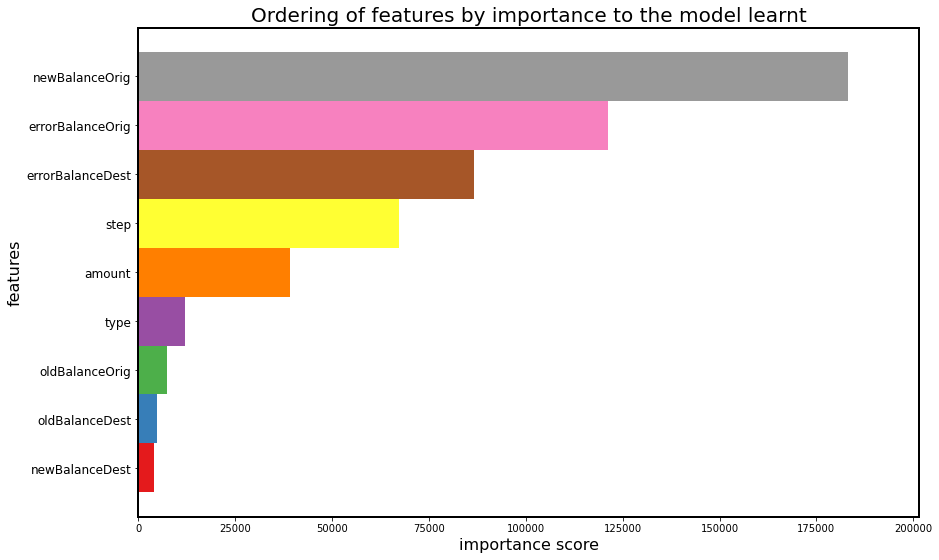

In [23]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);
